In [127]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
os.environ['TF_DETERMINISTIC_OPS'] = '0'
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp

In [128]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [129]:
def dataset():
    num_outputs = 10
    validation_size = 5000
    batch_size = 64
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    train_labels = tf.keras.utils.to_categorical(train_labels,num_outputs)
    test_labels = tf.keras.utils.to_categorical(test_labels,num_outputs)
    
    validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
    train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
    
    def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        image = tf.reshape(image, (28,28,1))
        # image = tf.image.grayscale_to_rgb(image, name=None)
        # image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label



    train_ds_size = len(list(train_ds))
    test_ds_size = len(list(test_ds))
    validation_ds_size = len(list(validation_ds))

    print("trainSize {}".format(train_ds_size))
    print("testSize {}".format(test_ds_size))

    train_ds = (train_ds
                    .map(augment_images)
                    .shuffle(buffer_size=train_ds_size,seed=42,reshuffle_each_iteration=False)
                    .batch(batch_size=batch_size, drop_remainder=True))

    test_ds = (test_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    validation_ds = (validation_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=validation_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    return (train_ds, test_ds, validation_ds)

train_ds, test_ds, validation_ds = dataset()

trainSize 55000
testSize 10000


In [130]:
def rotateImg(model, digit_one, evidence_func = tf.nn.relu, verbose=False):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    UB = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        evidence =evidence_func(_pred)
        
        if verbose:
            print(_pred, evidence, "label", np.argmax(_pred))
        alpha = evidence + 1
        
        # alpha = exp_evidence(logits)
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        M = alpha / S
        # E = alpha - 1
    
        # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
        
        
        u = K / S
        
        UBmax_ratio = np.amax(M)/1 - u
        print("UB", UBmax_ratio)
        UB.append(UBmax_ratio.numpy().mean())
        # print("uncert",u)
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
        print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    labels += ['UBRatio']
    plt.plot(ldeg,UB,marker='<',c='black',linestyle='dashed')
    
    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [131]:
num_classes=10
# Let us define some paths first
input_path = "./input/"

# Path to training images and corresponding labels provided as numpy arrays
kmnist_train_images_path = input_path+"kmnist-train-imgs.npz"
kmnist_train_labels_path = input_path+"kmnist-train-labels.npz"

# Path to the test images and corresponding labels
kmnist_test_images_path = input_path+"kmnist-test-imgs.npz"
kmnist_test_labels_path = input_path+"kmnist-test-labels.npz"

# Load the training data from the corresponding npz files
kmnist_train_images = np.load(kmnist_train_images_path)['arr_0']
kmnist_train_labels = np.load(kmnist_train_labels_path)['arr_0']

# Load the test data from the corresponding npz files
kmnist_test_images = np.load(kmnist_test_images_path)['arr_0']
kmnist_test_labels = np.load(kmnist_test_labels_path)['arr_0']

kmnist_train_labels = keras.utils.to_categorical(kmnist_train_labels, num_classes)
kmnist_test_labels = keras.utils.to_categorical(kmnist_test_labels, num_classes)
print(f"Number of training samples: {len(kmnist_train_images)} where each sample is of size: {kmnist_train_images.shape[1:]}")
print(f"Number of test samples: {len(kmnist_test_images)} where each sample is of size: {kmnist_test_images.shape[1:]}")

train_ds_kmnist = tf.data.Dataset.from_tensor_slices((kmnist_train_images, kmnist_train_labels))
test_ds_kmnist = tf.data.Dataset.from_tensor_slices((kmnist_test_images, kmnist_test_labels))
def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        image = tf.reshape(image, (28,28,1))
        # image = tf.image.grayscale_to_rgb(image, name=None)
        # image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label
batch_size=32
train_ds_kmnist_size = len(list(train_ds_kmnist))
train_ds_kmnist = (train_ds_kmnist
                .map(augment_images)
                .shuffle(buffer_size=train_ds_kmnist_size,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=True))

test_ds_kmnist = (test_ds_kmnist
                .map(augment_images)
                #   .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=batch_size, drop_remainder=True))



Number of training samples: 60000 where each sample is of size: (28, 28)
Number of test samples: 10000 where each sample is of size: (28, 28)


In [132]:
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl
  # return (px.pdf(X) * (log(px.pdf(X)) - log(qx.pdf(X)))).sum()

def _KL(alpha, beta, K ):
    # print("K:",K)
    # beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    beta = tf.cast(beta,tf.float32)
    alpha = tf.cast(alpha,tf.float32)
    S_alpha = tf.reduce_sum(alpha,keepdims=True)
    S_beta = tf.reduce_sum(beta,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl

import tensorflow.python.keras.backend as K


current_epoch = K.variable(0.)
        
        
class changeAlpha(tf.keras.callbacks.Callback):
    def __init__(self):
        super(changeAlpha, self).__init__()
        self.current_epoch = current_epoch
    def on_epoch_begin(self, epoch, logs={}):

        K.set_value(self.current_epoch, epoch)
        tf.print("current epoch", K.get_value(current_epoch))

        
        
def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function




In [133]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

def buildComparePlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        print("m",metric)
                        AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct + accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


In [134]:
batch_size = 128
epochs = 15

# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes),
#     ]
# )
# def justKL(labels,inputs):
def dirichlet_kl_divergence(alphas, target_alphas, precision=None, target_precision=None,
                            epsilon=1e-8):
    """
    This function computes the Forward KL divergence between a model Dirichlet distribution
    and a target Dirichlet distribution based on the concentration (alpha) parameters of each.
    :param alphas: Tensor containing concentation parameters of model. Expected shape is batchsize X num_classes.
    :param target_alphas: Tensor containing target concentation parameters. Expected shape is batchsize X num_classes.
    :param precision: Optional argument. Can pass in precision of model. Expected shape is batchsize X 1
    :param target_precision: Optional argument. Can pass in target precision. Expected shape is batchsize X 1
    :param epsilon: Smoothing factor for numercal stability. Default value is 1e-8
    :return: Tensor for Batchsize X 1 of forward KL divergences between target Dirichlet and model
    """
    if not precision:
        precision = tf.cast(tf.reduce_sum(alphas, keepdims=True),tf.float32)
    if not target_precision:
        target_precision = tf.cast(tf.reduce_sum(target_alphas, keepdims=True),tf.float32)
    alpha_sum = tf.reduce_sum(alphas)
    # tf.print(alpha_sum)
    target_alpha_sum = tf.reduce_sum(target_alphas)
    # tf.print(target_alpha_sum)
    precision_term = tf.compat.v1.lgamma( tf.cast(target_precision,tf.float32)) - tf.compat.v1.lgamma(tf.cast(precision,tf.float32))
    # tf.print(precision_term)
    # assert torch.all(torch.isfinite(precision_term)).item()
    # tf.print(tf.reduce_sum(tf.compat.v1.lgamma(alpha_sum + epsilon) - tf.compat.v1.lgamma(target_alpha_sum + epsilon)))
    # tf.print((target_alpha_sum - alpha_sum))
    # tf.print( (tf.compat.v1.digamma(target_alpha_sum + epsilon)- tf.compat.v1.digamma(target_precision + epsilon)))
    alphas_term = tf.reduce_sum(tf.compat.v1.lgamma(alpha_sum + epsilon) - tf.compat.v1.lgamma(target_alpha_sum + epsilon)
                            + (target_alpha_sum - alpha_sum) * (tf.compat.v1.digamma(target_alpha_sum + epsilon)- tf.compat.v1.digamma(target_precision + epsilon)), keepdims=True)
    # assert torch.all(torch.isfinite(alphas_term)).item()

    cost = tf.squeeze(precision_term + alphas_term)
    # tf.print("cost", cost)
    return cost  




class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        self.record = 0.0 

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = 0
        if epoch >= self.starting_epoch:
            val = tf.reduce_min([self.max_t, tf.cast((epoch - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


def loss_wrapper(lambda_callback: lambda_update):
    beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1
        lambda_callback.lambda_t
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        # tf.print(annealing_coef)
        
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp, 10)
        return (A + B) + C
    return custom_loss_function


crossentropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)






def evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

def evidence_crossentropy2(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        # A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        # B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
    
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return A # + C
        # return (A + B) + C
    return  cross_entropy_evidence

def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)



def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost




# model.compile(loss=loss_wrapper(current_epoch), optimizer="adam", metrics=["accuracy"])
# model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
# model.fit(train_ds, epochs=epochs,callbacks = [changeAlpha()])

In [135]:
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def UCE_loss(y_true, logits):
    alpha_t = exp_evidence(logits)
    alpha0 = tf.reduce_sum(alpha_t)
    n_classes = 10
    # Compute uncertain entropy
    dirichlet_expectation = tf.compat.v1.digamma(alpha_t) - (tf.expand_dims(tf.compat.v1.digamma(alpha0), -1))
    # y = tf.one_hot(self.y, self.n_classes)
    y = y_true
    loss_ent_unc = -(tf.reduce_sum(dirichlet_expectation * y, -1))
    loss = loss_ent_unc

#         # Regularization
#         if self.alpha > 0 or self.beta > 0:
#             ty = tf.tile(self.ty, [self.n_samples, 1])
#             x = tf.tile(self.x, [self.n_samples, 1])
#             t = tf.tile(self.tx, [self.n_samples, 1])
#             s = tf.tile(self.s, [self.n_samples])

#             t_sample = ty * tf.random_uniform(tf.shape(ty))

#             mark_emb = self.mark_embedding(x)
#             rnn_input = tf.concat([mark_emb, tf.expand_dims(t, -1)], -1)
#             # h = self.rnn(rnn_input, s, reuse=True)
#             log_alpha_t_sample, _, _, _ = self.Dirichlet(h, t_sample)
#             alpha_t_sample = tf.exp(log_alpha_t_sample)

#             mean = tf.digamma(self.alpha_t) - tf.tile(tf.expand_dims(tf.digamma(alpha0), -1), [1, 1, n_classes])
#             dist = tfp.Dirichlet(alpha_t_sample)
#             var = dist.variance()

#             mean_reg = (tf.reduce_mean(mean ** 2, -1))
#             var_reg = tf.reduce_mean(((n_classes-1)/(n_classes**2 * (n_classes + 1)) - var) ** 2, -1)
#             var_reg = self.aggregate(var_reg, s)

#             loss += self.alpha * mean_reg + self.beta * var_reg
    return loss
 

def loss_EDL(func=tf.compat.v1.digamma):
    def loss_func(p, logits): 
        # logits = tf.nn.softmax(logits)
        alpha = exp_evidence(logits)
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
    
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
        # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
    
        alp = E*(1-p) + 1 
        # B =  annealing_coef * KL(alp)
    
        return (A)
    return loss_func



def dirchlet_CE(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels, m)
        annealing_rate =  lambda_callback.lambda_t
        C =  annealing_rate * KL(alp,10)
        
        return loss#  + C
        # return (A + B) + C
    return  cross_entropy_evidence




In [137]:
#entropy train, without KL divergence
# loss_fn = loss_wrapper(1)
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

# outputs =[]
# inputs = keras.Input(shape=(28,28,1))
# targets = keras.Input(shape=(10,),name='targets')
# x = layers.Flatten(input_shape=(28,28))(inputs)
# x = layers.Dense(512, activation="relu")(x)
# x= layers.Dropout(0.2)(x)
# #exit 2
# x = layers.Dense(512, activation="relu")(x)
# x= layers.Dropout(0.2)(x)
# #exit 3
# x = layers.Dense(512, activation="relu")(x)
# x= layers.Dropout(0.2)(x)
# #exit 4
# x = layers.Dense(512, activation="relu")(x)
# x= layers.Dropout(0.2)(x)
# #exit 5
# x = layers.Dense(512, activation="relu")(x)
# x= layers.Dropout(0.2)(x)
# #exit 1 The main branch exit is refered to as "exit 1" or "main exit" to avoid confusion when adding addtional exits
# output = layers.Dense(10, name="output1")(x)
# output = layers.Softmax()(output)
# output = EvidenceEndpoint(10)(x,targets)



# outputs.append(output)
# print(len(outputs))
# model = keras.Model(inputs=[inputs], outputs=output, name="mnist_model_normal")
# # model.summary()

model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10),
    ]
)
 
def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        # evidence = exp_evidence(logits)
        # tf.print(logits,logits.shape)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5 * tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg)

        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return info_reg #+ D #+alp #+ C +  D  #+ info_reg #+ C + D
    return auxloss    


def IAD_loss(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    
    def IAD(labels, logits):
        evidence = tf.nn.softplus(logits)
        evidence = logits + 1
        # evidence = tf.nn.softmax(logits)
        # tf.print(evidence)
        # evidence = exp_evidence(logits)
        alpha = evidence + 1
        p = 4
        annealing_coef =  lambda_callback.lambda_t
        
        prob_c  = evidence * labels
        ic_mask = tf.cast(1 - labels,tf.float32)
        A = (1-tf.reduce_sum(prob_c,axis=1)) ** p
        B = tf.reduce_sum((ic_mask * evidence) ** p, axis=1)
        loss = (A + B) ** (1/p)
        
        
        
        bool_mask = tf.cast(labels,tf.bool)
        ic_mask = tf.cast(1 - labels,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        
        
#         A_ = (tf.exp(tf.math.lgamma(tf.reduce_sum(alpha,axis=1)))) / (tf.exp(tf.math.lgamma(tf.reduce_sum(alpha,axis=1)+p))) 
#         A_ = A_ ** (1/p)
        
#         B1_ = (tf.exp(tf.math.lgamma(tf.reduce_sum(ic_alpha_masked + p,axis=1)))) / tf.exp(tf.math.lgamma(tf.reduce_sum(ic_alpha_masked,axis=1)))
#         B2_ = tf.reduce_sum(tf.exp(tf.math.lgamma(ic_alpha_masked + p)),axis=1) / tf.exp(tf.math.lgamma(tf.reduce_sum(ic_alpha_masked,axis=1))) 
#         B_ = (B1_ + B2_) ** (1/p)
#         loss = A_ * B_
        
        
        
#         bool_mask = tf.cast(labels,tf.bool)
#         ic_mask = tf.cast(1 - labels,tf.bool)
#         ic_bool_mask = tf.cast(ic_mask,tf.bool)
#         ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5 * tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg)
        
        # annealing_coef =  0.0001
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return loss #+ info_reg + D  #+ info_reg #+ C + D
    return IAD   

def EDL_Loss(lambda_callback: lambda_update):
    
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        # evidence = exp_evidence(logits)
        # tf.print(logits,logits.shape)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        # tf.print("annealing", annealing_coef)
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5 * tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg)

        alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return (A + B) + info_reg + D#C + D #+alp #+ C +  D  #+ info_reg #+ C + D
    return custom_loss_function  

lambda_callback = lambda_update(100, 0., max_t = 1., starting_epoch =0)
auxlossMetric = auxLoss(lambda_callback)

BREV_loss = EDL_Loss(lambda_callback)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# model = tf.keras.models.load_model("./models/mnist_blank.hdf5")
# for i in range(5):
    # annealing = tf.minimum(1,tf.cast((i)/10,tf.float32))
    # print("annealing_coef:", annealing)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True)
model.compile(loss=BREV_loss, 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999),
              # optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=["accuracy"])
model.fit(train_ds, validation_data=test_ds, validation_freq=5, epochs=30,callbacks=[lambda_callback])
# model.compile(loss=crossentropy, optimizer="adam", metrics=["accuracy"])
# model.fit(train_ds, epochs=5)

annealing coef updated to: 0
Epoch 1/30
859/859 [==============================] - 7s 7ms/step - loss: 0.1722 - accuracy: 0.8979
annealing coef updated to: 0.01
Epoch 2/30
859/859 [==============================] - 7s 7ms/step - loss: 0.0748 - accuracy: 0.9654
annealing coef updated to: 0.02
Epoch 3/30
859/859 [==============================] - 6s 7ms/step - loss: 0.0634 - accuracy: 0.9735
annealing coef updated to: 0.03
Epoch 4/30
859/859 [==============================] - 7s 7ms/step - loss: 0.0630 - accuracy: 0.9751
annealing coef updated to: 0.04
Epoch 5/30
859/859 [==============================] - 7s 8ms/step - loss: 0.0623 - accuracy: 0.9761 - val_loss: 0.0384 - val_accuracy: 0.9855
annealing coef updated to: 0.05
Epoch 6/30
859/859 [==============================] - 7s 7ms/step - loss: 0.0583 - accuracy: 0.9785
annealing coef updated to: 0.06
Epoch 7/30
859/859 [==============================] - 7s 7ms/step - loss: 0.0587 - accuracy: 0.9793
annealing coef updated to: 0.07
Epoch

In [108]:
model.evaluate(test_ds)

156/156 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.9416


[0.1916474550962448, 0.9416065812110901]

In [118]:
from scipy.special import logsumexp
def getPredictions_Energy(model, input_set, stopping_point=None,num_classes=10):
    '''
        Function for collecting the model's predictions on a test set. 

        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
                # evidence =tf.nn.softplus(prediction)
                # alpha = evidence +1
                # S = sum(alpha)
                # E = alpha - 1
                # Mass = alpha / S
                # u = num_classes / S
                # Uncert[k].append(u.numpy().mean())
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                Energy[k].append( -(logsumexp(np.array(prediction))))
                Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                dirch = evaluate.dirichlet_prior_network_uncertainty([prediction])
                # print(dirch)
                conf[k].append(dirch["confidence_alea_uncert."])
                entropy_of_exp[k].append(dirch["entropy_of_expected"])
                expected_entropy[k].append(dirch["expected_entropy"])
                mutual_info[k].append(dirch["mutual_information"])
                epkl[k].append(dirch["EPKL"])
                dentropy[k].append(dirch["differential_entropy"])
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        df = pd.DataFrame({"x":Results[j],"y":Labels[j],
                           # "uncert":Uncert[j],
                            "energy":Energy[j],
                            'entropy':Entropy[j],
                            'calibration':calibration[j],
                            "confidence_alea_uncert":conf[j],
                            "entropy_of_expected":entropy_of_exp[j],
                            "expected_entropy":expected_entropy[j],
                            "mutual_information":mutual_info[j],
                            "EPKL":epkl[j],
                            "differential_entropy":dentropy[j],
                          })
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

In [124]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 1


In [125]:
output_OOD = getPredictions_Energy(model, test_ds_kmnist,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 1


metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.03994160974762676 Best Threshold=-124.77774810791016, G-Mean=0.9064716527606501, TPR=0.9107142857142857, FPR=0.09775121555915721


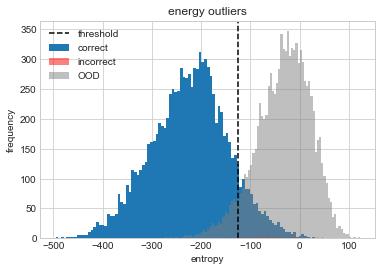

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988782 -124.777748         8918           629              8907           0.934115             0.932963
metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.13169281083584164 Best Threshold=2.56380024483519e-36, G-Mean=0.8580052532395765, TPR=0.7589285714285714, FPR=0.029983792544570502


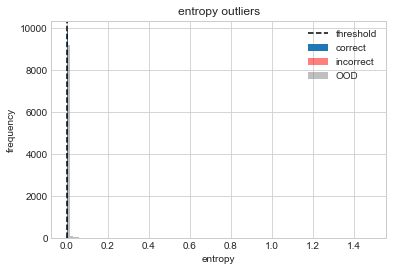

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy     Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988782  2.563800e-36         9604          2591              9576           0.787536              0.78524


In [126]:
#CE adam
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=True)
# model.save('./models/journal_models/mnist_edl100_adam_2.hdf5')

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.07423981930960086 Best Threshold=-12.762990951538086, G-Mean=0.8602493529386649, TPR=0.8020833333333334, FPR=0.07736650485436893


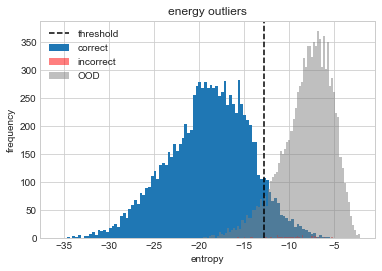

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.990385 -12.762991         9143           705              9123           0.928412             0.926381


In [122]:
#EDL softplus, ADAM, growth 0
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
# model.save('./models/journal_models/mnist_edl100_adam_2.hdf5')

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.0250918261502587 Best Threshold=-407.8265380859375, G-Mean=0.9243000590952679, TPR=0.9380530973451328, FPR=0.08925134231587478


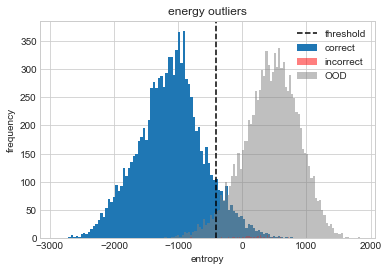

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988682 -407.826538         8998           362              8990           0.961325              0.96047


In [83]:
#EDL softplus, ADAM, growth 100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
# model.save('./models/journal_models/mnist_edl100_adam_2.hdf5')

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.026481819410651534 Best Threshold=-554.7437133789062, G-Mean=0.9337456365415989, TPR=0.9833333333333333, FPR=0.11334144363341443


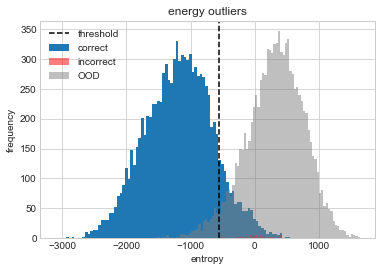

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.987981 -554.743713         8749           401              8746           0.956175             0.955847


In [77]:
#EDL softplus, ADAM, growth 100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
# model.save('./models/journal_models/mnist_edl100_adam_2.hdf5')

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.0326533602553079 Best Threshold=-329.72528076171875, G-Mean=0.9302946270297775, TPR=0.9365079365079365, FPR=0.07587745993102049


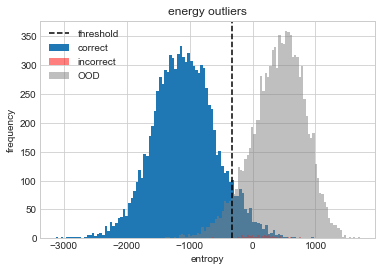

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984        0.98738 -329.725281         9119           570              9110            0.94117             0.940242


In [63]:
#EDL softplus, ADAM, growth 50
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
# model.save('./models/journal_models/mnist_edl100_adam_2.hdf5')

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.023078240272972683 Best Threshold=-444.59765625, G-Mean=0.950152274841962, TPR=0.9823008849557522, FPR=0.08094417992098064


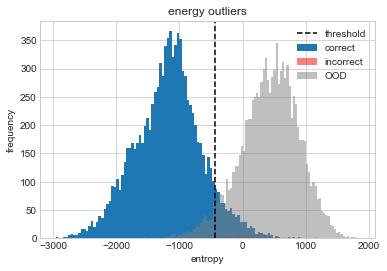

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988682 -444.597656         9075           406              9072           0.957178             0.956861


In [ ]:
#EDL softplus, ADAM, growth 100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
# model.save('./models/journal_models/mnist_edl100_adam_2.hdf5')

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.025579219357064635 Best Threshold=-371.4841003417969, G-Mean=0.9275357838081846, TPR=0.9537037037037037, FPR=0.09791413527744026


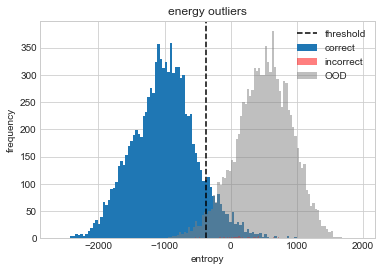

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.989183  -371.4841         8915           286              8909           0.968916             0.968264


In [45]:
#EDL softplus, ADAM, growth 100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
model.save('./models/journal_models/mnist_edl100_adam.hdf5')

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.020422594850948512 Best Threshold=-60.14104080200195, G-Mean=0.9510222475139507, TPR=0.9722222222222222, FPR=0.06971544715447155


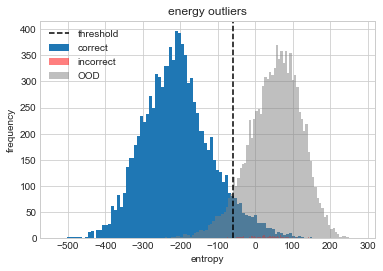

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.985577 -60.141041         9159           668              9154           0.932024             0.931515


In [39]:
#EDL softplus, SGD
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)


metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.02834217252304724 Best Threshold=-310.9222106933594, G-Mean=0.9337274836931914, TPR=0.9436619718309859, FPR=0.07610241820768136


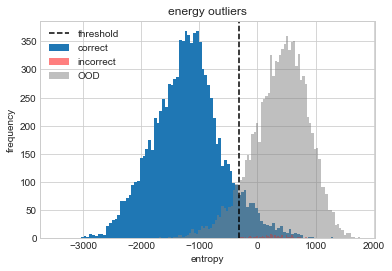

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.985777 -310.922211         9102           847              9093           0.914866             0.913961


In [35]:
#EDL softplus, ADAM
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)


metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.26725995501251953 Best Threshold=-1.4522093534469604, G-Mean=0.6760530009043719, TPR=0.6276276276276276, FPR=0.2717853072220495


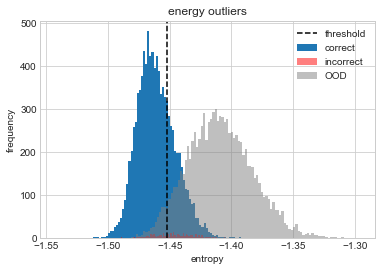

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.966647  -1.452209         7153           439              7028           0.942176             0.925711


In [31]:
#info_reg, no activation, alpha correction, ADAM
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)


metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.06492297840935402 Best Threshold=-12.079521179199219, G-Mean=0.8725732688194201, TPR=0.9017857142857143, FPR=0.15569286871961102


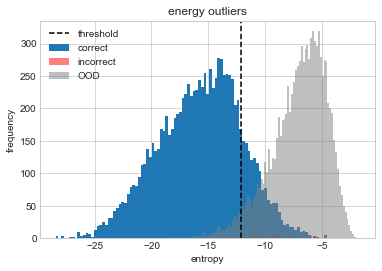

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988782 -12.079521         8347           373              8335           0.957225             0.955849
metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.021415185806899745 Best Threshold=0.03797083720564842, G-Mean=0.9332227618932054, TPR=0.9642857142857143, FPR=0.09683954619124797


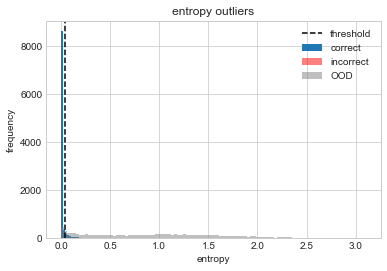

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988782   0.037971         8921           555              8916           0.941431             0.940903
metric:  calibration threshold:  gmean
m calibration
metric calibration
calibration  lr_auc 0.978476282125492 Best Threshold=0.9961816072463989, G-Mean=0.9335367140507473, TPR=0.9037682333873582, FPR=0.03571428571428571


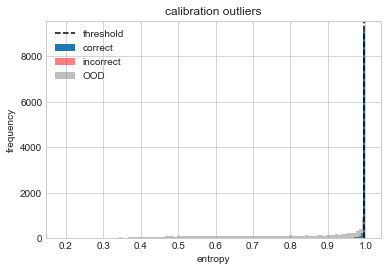

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988782   0.996182         8926           569              8922           0.940074             0.939652


In [118]:
#CE
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=True)
buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.0296955965483277 Best Threshold=-64.45365142822266, G-Mean=0.9258095682166124, TPR=0.9736842105263158, FPR=0.11971114727420668


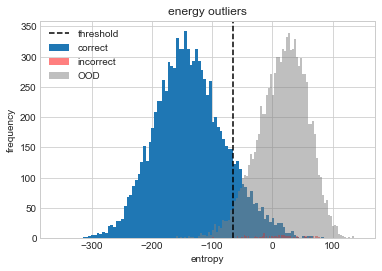

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.984776 -64.453651         8660           355              8655           0.960621             0.960067


In [95]:
#EDL info_reg, softplus
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.019985943478635314 Best Threshold=-29.500097274780273, G-Mean=0.9497803121104657, TPR=0.9772727272727273, FPR=0.07693869265123833


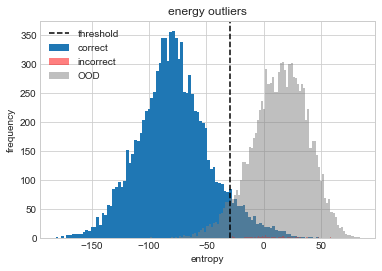

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.986779 -29.500097         9098           523              9094            0.94564             0.945224


In [71]:
#edl ALP aux
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.04332865226210714 Best Threshold=-74.59278106689453, G-Mean=0.8979158789494238, TPR=0.8918918918918919, FPR=0.09601944697660286


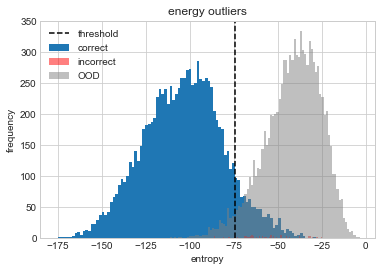

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.988882 -74.592781         8938           363              8925           0.960972             0.959574


In [64]:
#edl no auxliary
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.023383431093563944 Best Threshold=-44.065467834472656, G-Mean=0.9492536830461021, TPR=0.9694656488549618, FPR=0.0705368923170608


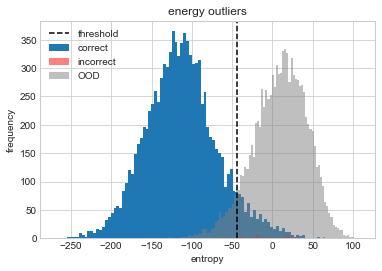

['exit_1']
  Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0    exit_1       9984        9984       0.986879 -44.065468         9163           660              9158           0.932811             0.932302


In [58]:
#EDL info_reg aux
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=False,plot=True)

In [ ]:
# IAD loss  15epochs, branch1, frozen layers
# buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=True)

In [ ]:
# IAD loss  15epochs, branch1, frozen layers
# buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=False,plot=True)

In [ ]:
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
# print(outputs['uncert'].tolist())
Correct = outputs.loc[(outputs['correct'] == True)]
Incorrect = outputs.loc[(outputs['correct'] == False)]
print(Correct)
print(Incorrect)
_ = plt.hist([Correct['uncert'].tolist(),Incorrect['uncert'].tolist()], bins=10)  # arguments are passed to np.histogram
# plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
   
# SVM reliability diagram with calibration
def cumulativeClassification(y, prob, bins =10, thresholdType = ">="):
    from sklearn.datasets import make_classification
    from sklearn.svm import SVC
    from sklearn.calibration import CalibratedClassifierCV
    from sklearn.model_selection import train_test_split
    from sklearn.calibration import calibration_curve
    from matplotlib import pyplot
    print("max",max(prob))
    # linspace = np.linspace(0,math.ceil(max(prob)),num=bins)
    linspace = np.linspace(0,.1,num=bins)
    # pyplot.hist(prob,bins=linspace,density=False)
    accuracy = []
    throughputs = []
    for point in linspace:
        true = 0
        false = 0   
        throughput = 0
        for i, p in enumerate(prob):
            
            if thresholdType == "<=":
                if p >= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
            else:
                if p <= point:
                    throughput = throughput + 1
                    if y[i] ==True:
                        true = true +1
                    if y[i] ==False: 
                        false = false + 1
        try:
            accuracy.append(true/(true+false))
            throughputs.append(throughput/len(prob))
            # print(point, throughput/len(prob))                
        except:
            accuracy.append(0)
            throughputs.append(0)
            pass
    # print(throughputs)
    pyplot.plot(linspace[:len(throughputs)], throughputs,label="Accepted (y) for threshold (x)")
    fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # plot calibrated reliability
    # pyplot.plot(mpv, fop, marker='.',label="calibration")
    # fop, mpv = calibration_curve(y,prob, n_bins=bins, normalize=True)
    # plot perfectly calibrated
    # pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot calibrated reliability
    pyplot.plot(linspace[:len(accuracy)], accuracy, marker='.',color='blue',label="Accuracy")
    pyplot.legend(loc="upper right")
    pyplot.legend(bbox_to_anchor=(1.1, 1.05))
    pyplot.xlabel('Probability/Evidence')
    # pyplot.set_ylabel('Rating')
    pyplot.show()
    
cumulativeClassification(outputs['correct'].tolist(),outputs['uncert'].tolist(),20)

In [ ]:
# test_img = tf.image.rgb_to_grayscale(test_img, name=None)
# pred = model.predict(tf.reshape(test_img,(1,32,32)))
# print(pred, tf.nn.softplus(pred))
# rotateImg(model,test_img, exp_evidence)
# 324.33612 -195.3844  -328.90497 -348.173   -302.2171  -291.78085  -418.81058 -277.24625 -335.44376 -236.58258
# 2278.2148 -3066.1064 -3517.2793 -3051.9978 -2099.7322 -2623.3499  -2526.0488 -3102.543  -2939.1077 -3429.5134
num_classes = 10 
for i in range(10):    
    kmnist_digit = x_train[i]
    # kmnist_digit = tf.image.rgb_to_grayscale(kmnist_digit, name=None)
    kmnist_label = y_train[i]
    plt.imshow(kmnist_digit)
    plt.show()
    _pred=model.predict(tf.reshape(kmnist_digit,(1,28,28)))
    evidence =exp_evidence(_pred)
    alpha = evidence +1
    # alpha = exp_evidence(logits)
    S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
    E = alpha - 1
    
    Mass = alpha / S
    # A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
    u = num_classes / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
    print(_pred)
    print("label", np.argmax(_pred),":",np.argmax(kmnist_label), "uncert", u.numpy().mean(), "beliefMax", np.amax(Mass).mean() )

In [ ]:
digit_one = x_train[6]
plt.imshow(digit_one)
plt.show()
rotateImg(model,digit_one, exp_evidence, verbose=False)

In [ ]:
from scipy.special import gammaln, digamma
def dirichlet_prior_network_uncertainty(logits, epsilon=1e-10, alpha_correction=True):
    """
    :param logits:
    :param epsilon:
    :return:
    """

    logits = np.asarray(logits, dtype=np.float64)
    alphas = np.exp(logits)

    alphas = np.clip(alphas, 0, np.finfo(np.dtype("float32")).max)

    if alpha_correction:
        alphas = alphas + 1

    alpha0 = np.sum(alphas, axis=1, keepdims=True)
    probs = alphas / alpha0

    conf = np.max(probs, axis=1)

    entropy_of_exp = -np.sum(probs * np.log(probs + epsilon), axis=1)
    expected_entropy = -np.sum(
        (alphas / alpha0) * (digamma(alphas + 1) - digamma(alpha0 + 1.0)), axis=1
    )

    mutual_info = entropy_of_exp - expected_entropy

    epkl = np.squeeze((alphas.shape[1] - 1.0) / alpha0)

    dentropy = (
        np.sum(
            gammaln(alphas) - (alphas - 1.0) * (tf.compat.v1.digamma(alphas) - tf.compat.v1.digamma(alpha0)),
            axis=1,
            keepdims=True,
        )
        - gammaln(alpha0)
    )

    uncertainty = {
        "confidence_alea_uncert.": conf,
        "entropy_of_expected": -entropy_of_exp,
        "expected_entropy": -expected_entropy,
        "mutual_information": -mutual_info,
        "EPKL": -epkl,
        "differential_entropy": -np.squeeze(dentropy),
    }

    # return {k: torch.from_numpy(v).float() for k, v in uncertainty.items()}
    return uncertainty

In [ ]:
digit_one = x_train[6]
plt.imshow(digit_one)
plt.show()
# rotateImg(model,digit_one, tf.nn.softplus, verbose=True)
_pred = model.predict(digit_one.reshape(1,28,28))
print(_pred)
dirichlet_prior_network_uncertainty(_pred)

In [ ]:
digit_one = x_train[5]
plt.imshow(digit_one)
plt.show()
rotateImg(model,digit_one, exp_evidence, verbose=False)

In [ ]:
digit_one = x_train[6]
plt.imshow(digit_one)
plt.show()
rotateImg(model,digit_one, True)

In [ ]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(227,227,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function


def metric_wrapper(annealing_coef):
    def detailed_losses(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_sum(A+B), tf.reduce_sum(C)) # Note the `axis=-1`
    return detailed_losses

# #example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
# for i in range(4):
#     print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
#     # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
#     model.compile(loss=loss_wrapper(0), optimizer="adam", metrics=["accuracy", detailed_losses])
#     model.fit(train_ds,epochs = 1)
    

In [ ]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=(28,28,1)),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes),
#     ]
# )
# model.save("./models/mnist_blank.hdf5")

In [ ]:

#entropy version



def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        # tf.print(tf.reduce_sum(A+B), tf.reduce_sum(C))
        
        return (A + B) + C
    return custom_loss_function

def lossMetric(annealing_coef):
    def lossMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_mean(A+B)) # Note the `axis=-1`
    return lossMetric

def klMetric(annealing_coef):
    def klMetric(p, logits):
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        # tf.print(logits)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (tf.reduce_mean(C)) # Note the `axis=-1`
    return klMetric

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))


def loss_EDL(annealing):
    def loss_func(p, logits): 
        func=tf.compat.v1.digamma
        E = exp_evidence(logits)
        alpha = E + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        # E = alpha - 1
    
        A = tf.reduce_sum(p * (func(S) - func(alpha)), axis=1, keepdims=True)
    
        # annealing_coef = tf.minimum(1.0, tf.cast(global_step/annealing_step,tf.float32))
    
        alp = E*(1-p) + 1 
        B =  annealing * KL(alp,10)
    
        return (A + B)
    return loss_func

def evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss + C
        # return (A + B) + C
    return  cross_entropy_evidence

model = tf.keras.models.load_model("./models/mnist_blank.hdf5")
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(10):
    # if i > 5:
    # annealing = tf.minimum(1,tf.cast((i+1)/100,tf.float32))
    annealing = 0
    # else:
        # annealing = 0
    print("annealing_coef:", annealing)
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_EDL(annealing), optimizer="adam", metrics=["accuracy",lossMetric(annealing),klMetric(annealing)])
    model.fit(train_ds,epochs = 1)
    
    

In [ ]:
model = tf.keras.models.load_model("./models/mnist_blank.hdf5")
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(10):
    # if i > 5:
    # annealing = tf.minimum(1,tf.cast((i+1)/100,tf.float32))
    annealing = 0
    # else:
        # annealing = 0
    print("annealing_coef:", annealing)
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_wrapper(annealing), optimizer="adam", metrics=["accuracy",lossMetric(annealing),klMetric(annealing)])
    model.fit(train_ds,epochs = 1)

In [ ]:
# pred = model.predict(tf.reshape(digit_one,(1,28,28)))
# print(pred, tf.nn.softplus(pred))
digit_one = x_train[10]
plt.imshow(digit_one)
plt.show()
rotateImg(model,digit_one)

In [ ]:
print(tf.nn.softplus(-50.0))

In [ ]:
print((model.predict(tf.reshape(digit_one,(1,28,28)))))
rotateImg(model)

In [ ]:
def rotateImg(model, digit_one):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        print(_pred, tf.nn.softplus(_pred))
        evidence = tf.nn.softplus(_pred)
        alpha = evidence + 1
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [ ]:
def rotateImg(model,digit_one, verbose=False):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        evidence = tf.nn.softplus(_pred)
        alpha = evidence + 1
        u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty
        prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        # print("prob", evidence)
        # print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        # print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)

    print(labels)
    for j in range(len(labels)):
        plt.plot(ldeg,lp[:,j],marker=marker[j])
    labels += ['uncertainty']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass')
    # plt.yscale("log")
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    return(uncert)

In [ ]:
model.evaluate(test_ds)

In [ ]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(4):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
    annealing = tf.minimum(1,tf.cast(i/10,tf.float32))
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    # model.compile(loss=evidence_crossentropy(annealing), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)
    

In [ ]:
import matplotlib.pyplot as plt
digit_one = x_train[6]

print(np.argmax(model.predict(digit_one.reshape(1,28,28))))
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [ ]:
def rotate_img_crossevidence(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
    #     print(_pred)
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1


        # evidence = tf.nn.relu(_pred)
        # alpha = evidence + 1

        u = tf.reduce_sum(evidence, axis=1, keepdims=True) #uncertainty

        # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        print("prob", evidence)
        print("u", u.numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += evidence.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(evidence[0])
        print(u.numpy())
        pred.append(pred)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    for j in range(len(labels)):
        print(labels[j])
        print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

In [ ]:
rotate_img_crossevidence(model)

In [ ]:
import tensorflow_addons as tfa
linspace = np.linspace(1,180,num=18)
digit_one = x_train[6]
import matplotlib.pyplot as plt
Mdeg = 180 
Ndeg = int(Mdeg/10)+1
K = 10
# print(linspace)
pred = []
uncert = []
label = []
answer = []
ldeg = []
lp = []
lu=[]
scores = np.zeros((1,K))
threshold = 0.001
Results = pd.DataFrame()
rimgs = []
K=10
from PIL import Image

for i in linspace:
    i = int(i)
    radians = i* np.pi/180
    # print(radians)
    rotate = tfa.image.rotate(digit_one, tf.constant(radians))
    rimg = rotate
    rimgs.append(rimg.numpy().reshape(28,28))
#     rimgs.append(rotate)
    _pred=model.predict(tf.reshape(rotate,(1,28,28)))
#     print(_pred)
    # evidence = tf.nn.relu(_pred)
    evidence = tf.nn.softplus(_pred)
    # alpha = evidence + 1
    
    
    # evidence = tf.nn.relu(_pred)
    alpha = evidence + 1

    u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty

    prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
    print("prob", evidence)
    print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
    # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
    # prob = evidence/tf.reduce_sum(evidence, 1) 
#     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
    scores += prob.numpy().astype("float") >= threshold
#     print("scores",scores)
    lp.append(prob[0])
    print(u.numpy())
    pred.append(prob)
    uncert.append(u.numpy().mean())
    label.append(1)
    answer.append(np.argmax(_pred))
    ldeg.append(i)
labels = np.arange(10)[scores[0].astype(bool)]
# print("labels",labels)
lp = np.array(lp)[:,labels]
# c = ['black','blue','red','brown','purple','cyan']
marker = ['s','^','o']*4
labels = labels.tolist()
# print("lp",lp)

print(labels)
for j in range(len(labels)):
    # print(lp[:,j], answer[j])
    
    
    plt.plot(ldeg,lp[:,j],marker=marker[j])
    


labels += ['uncertainty']
plt.plot(ldeg,uncert,marker='<',c='red')

plt.legend(labels)
 
plt.xlim([0,Mdeg])  
plt.xlabel('Rotation Degree')
plt.ylabel('Belief Mass')
plt.yscale("log")
plt.show()

img = Image.new('L', (28*len(rimgs), 28))
x_offset =0
for im in rimgs:
#     print(im)
    _im = Image.fromarray(np.uint8((im)*255))
    img.paste(_im,(x_offset,0))
    x_offset += _im.size[0]
    
plt.figure(figsize=[6.2,100])
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
#     print(pred, np.argmax(pred))
#     _ = plt.imshow(rotate)
#     plt.show()
print(uncert)

In [ ]:
def rotate_img_entropy():
    def calcEntropy_Tensors2(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies

    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        prob = _pred
        # evidence = tf.nn.relu(_pred)
        # evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        
        u = calcEntropy_Tensors2(prob)
        print("prob", _pred)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += _pred.astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    print(labels)
    for j in range(len(labels)):
        print(lp[:,j], answer[j])


        plt.plot(ldeg,lp[:,j],marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass / Entropy Score')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

In [ ]:
def rotate_img_crossentropy(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        prob = np.amax(evidence)
        # u = prob
        u = tf.reduce_sum(evidence, axis=1, keepdims=True).numpy() #uncertainty
        # u = np.reduce_sum(evidence)
        print("prob", evidence)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.astype("float") 
    #     print("scores",scores)
    
    
    
        lp.append(evidence[0])
        pred.append(prob)
        uncert.append(u.mean())
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    plt.yscale('log')
    
    for j in range(len(labels)):
        print(labels[j])
        # print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Certanity']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

In [ ]:
rotate_img_crossentropy(model2)